In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
import time

import matplotlib.pylab as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as ltb

import seaborn as sns
sns.set(style="whitegrid")

Выберем параметр:

In [2]:
param = 'x'

In [3]:
def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values) 
        / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))

In [4]:
#Тренировочные данные
df_train = pd.read_csv('data/Track 1/train_final.csv')
#Тестовые данные
df_test = pd.read_csv('data/Track 1/test_final.csv')

df_train = df_train.drop(['Unnamed: 0'], axis=1)
df_test = df_test.drop(['Unnamed: 0'], axis=1)

Подготовим данные:

In [5]:
df_train = df_train.drop(['time', 'date'], axis=1)
neworder = ['id', 'sat_id', 'x','y','z','Vx','Vy','Vz', 'x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']
df_train=df_train.reindex(columns=neworder)
df_train['sat_id'] = df_train['sat_id'].astype('int64')

df_test = df_test.drop(['time', 'date'], axis=1)
neworder = ['id', 'sat_id', 'x_sim','y_sim','z_sim','Vx_sim','Vy_sim','Vz_sim']
df_test = df_test.reindex(columns=neworder)
df_test['sat_id'] = df_test['sat_id'].astype('int64')

Рассмотрим данные:

In [6]:
df_train.head(3)

,id,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,1819.0,1,10390.313089,-2796.458271,3179.562085,2.520477,6.149930,-2.827599,10405.813755,-2771.180760,3166.926302,2.508879,6.152996,-2.826227
1,NaN,1,10428.328529,-2424.698448,2989.854516,2.348307,6.134658,-2.847816,10443.297921,-2399.492986,2977.491684,2.337052,6.137385,-2.846235
2,NaN,1,10466.343970,-2052.938626,2800.146946,2.176136,6.119386,-2.868033,10480.782087,-2027.805212,2788.057066,2.165225,6.121774,-2.866242


In [7]:
df_test.head(3)

,id,sat_id,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927.0,1,-13579.030167,-14227.483997,6360.466650,4.307509,-0.730029,0.828370
1,NaN,1,-13296.178407,-14239.843338,6395.543856,4.342584,-0.680342,0.804909
2,NaN,1,-13013.326648,-14252.202678,6430.621062,4.377659,-0.630655,0.781448


Выберем один спутник:

In [8]:
sat = 3
df_train_one_sat = df_train.query('sat_id == @sat')
df_test_one_sat = df_test.query('sat_id == @sat')

Напишем функцию по созданию новых фичей:

In [9]:
def create_new_features(df_one_sat):
    df_one_sat['sum_x_y'] = df_one_sat['x_sim'] + df_one_sat['y_sim']
    df_one_sat['sum_x_z'] = df_one_sat['x_sim'] + df_one_sat['z_sim']
    df_one_sat['sum_y_z'] = df_one_sat['y_sim'] + df_one_sat['z_sim']

    df_one_sat['dif_x_y'] = df_one_sat['x_sim'] - df_one_sat['y_sim']
    df_one_sat['dif_x_z'] = df_one_sat['x_sim'] - df_one_sat['z_sim']
    df_one_sat['dif_y_z'] = df_one_sat['y_sim'] - df_one_sat['z_sim']

    df_one_sat['mul_x_y'] = df_one_sat['x_sim'] * df_one_sat['y_sim']
    df_one_sat['mul_x_z'] = df_one_sat['x_sim'] * df_one_sat['z_sim']
    df_one_sat['mul_y_z'] = df_one_sat['y_sim'] * df_one_sat['z_sim']

    df_one_sat['div_x_y'] = df_one_sat['x_sim'] / df_one_sat['y_sim']
    df_one_sat['div_x_z'] = df_one_sat['x_sim'] / df_one_sat['z_sim']
    df_one_sat['div_y_z'] = df_one_sat['y_sim'] / df_one_sat['z_sim']

    df_one_sat['sum_Vx_Vy'] = df_one_sat['Vx_sim'] + df_one_sat['Vy_sim']
    df_one_sat['sum_Vx_Vz'] = df_one_sat['Vx_sim'] + df_one_sat['Vz_sim']
    df_one_sat['sum_Vy_Vz'] = df_one_sat['Vy_sim'] + df_one_sat['Vz_sim']

    df_one_sat['dif_Vx_Vy'] = df_one_sat['Vx_sim'] - df_one_sat['Vy_sim']
    df_one_sat['dif_Vx_Vz'] = df_one_sat['Vx_sim'] - df_one_sat['Vz_sim']
    df_one_sat['dif_Vy_Vz'] = df_one_sat['Vy_sim'] - df_one_sat['Vz_sim']

    df_one_sat['mul_Vx_Vy'] = df_one_sat['Vx_sim'] * df_one_sat['Vy_sim']
    df_one_sat['mul_Vx_Vz'] = df_one_sat['Vx_sim'] * df_one_sat['Vz_sim']
    df_one_sat['mul_Vy_Vz'] = df_one_sat['Vy_sim'] * df_one_sat['Vz_sim']
    return df_one_sat

In [10]:
df_train_one_sat = create_new_features(df_train_one_sat)
df_test_one_sat = create_new_features(df_test_one_sat)

Здесь можно выбрать интересующие фичи:

In [11]:
features = ['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim',
            'sum_x_y', 'sum_x_z', 'sum_y_z',
            'dif_x_y', 'dif_x_z', 'dif_y_z',
            'mul_x_y', 'mul_x_z',
            'sum_Vx_Vy', 'sum_Vx_Vz', 'sum_Vy_Vz',
            'dif_Vx_Vy',
            'mul_Vx_Vy',
            'div_x_y'
            ]
target = [param]

Готовим данные для обучения и проверки:

In [12]:
features_train = df_train_one_sat[features]
target_train = df_train_one_sat[target]

features_test = df_test_one_sat[features]

In [13]:
model_LTB = ltb.LGBMRegressor(silent=True, random_state=42)

In [14]:
grid_param = {
    'n_estimators': [3000],
    'max_depth': [11, 12, 13],
    'learning_rate': [0.3, 0.4, 0.2],
    'boosting_type': ['gbdt']
}

In [15]:
gd_sr = GridSearchCV(estimator=model_LTB,
                     param_grid=grid_param,
                     scoring='neg_mean_absolute_error',
                     cv=5,
                     n_jobs=-1)

In [16]:
start_time = time.time()

gd_sr.fit(features_train, target_train)
best_parameters = gd_sr.best_params_
print('best parameters:', best_parameters)
print()
best_result = gd_sr.best_score_
print('best_result:', best_result)
print()
best_model = gd_sr.best_estimator_

print("--- %s seconds ---" % (time.time() - start_time))

best parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.3, 'max_depth': 13, 'n_estimators': 3000}

best_result: -2182.4265138482733

--- 152.94242119789124 seconds ---


In [17]:
# обучаем модель
best_model.fit(features_train, target_train)
# предсказания на выборке train
df_train_one_sat[param + '_pred'] = best_model.predict(features_train)
# предсказания на выборке test
df_test_one_sat[param + '_pred'] = best_model.predict(features_test)

In [18]:
print('TRAIN sMAPE', param, ':', smape(df_train_one_sat[param + '_pred'], df_train_one_sat[param]))
print(' TEST sMAPE', param, ':', smape(df_test_one_sat[param + '_pred'], df_test_one_sat[param + '_sim']))

TRAIN sMAPE x : 0.007616438705035699
 TEST sMAPE x : 0.21779949574081203


Оценим полученные результаты:

На обучающей выборке:

In [19]:
df_train_one_sat[[param, param + '_pred', param + '_sim']].head(3)

,x,x_pred,x_sim
89162,-21820.314775,-22083.576082,-20973.501149
89163,-21595.355885,-21306.230188,-20746.067912
89164,-21370.396995,-21675.587521,-20518.634674


На тестовой выборке:

In [20]:
df_test_one_sat[[param + '_pred', param + '_sim']].head(3)

,x_pred,x_sim
80182,53107.653897,42202.355411
80183,53139.048788,42095.696947
80184,53040.475704,41989.038483


### Графики

### Train

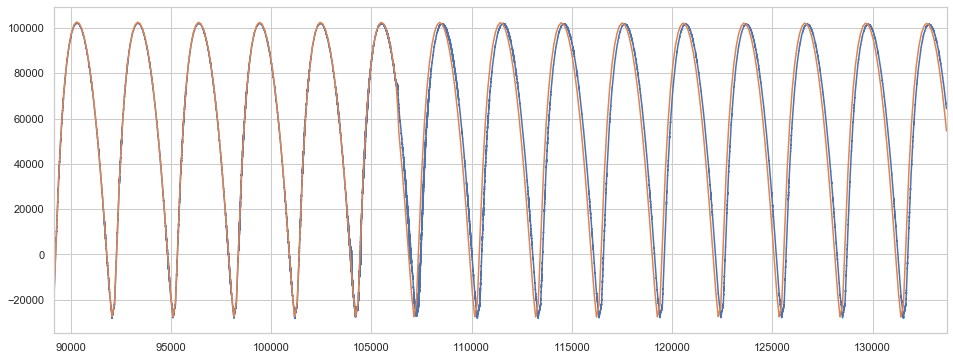

In [21]:
fig, ax = plt.subplots(figsize=(16,6))
df_train_one_sat[param + '_pred'].plot()
df_train_one_sat[param + '_sim'].plot()

### Test

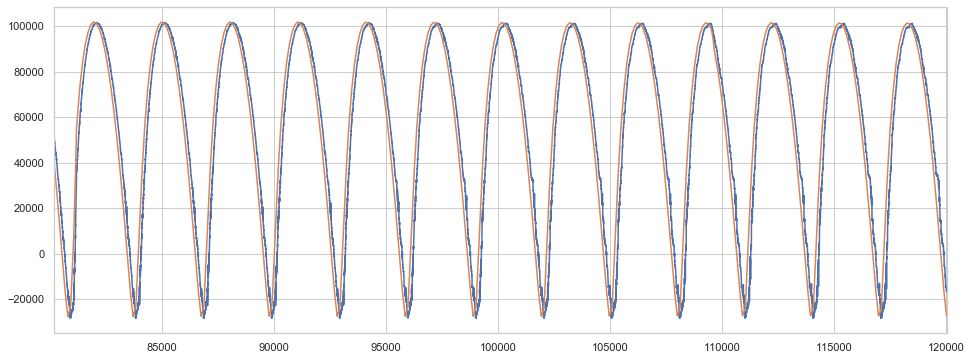

In [22]:
fig, ax = plt.subplots(figsize=(16,6))
df_test_one_sat[param + '_pred'].plot()
df_test_one_sat[param + '_sim'].plot()